In [14]:
from PIL import Image, ImageOps
import os
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import pycocotools.mask as cmask

In [3]:
# CONSTANTS
SIDE_LENGTH = 64
COCO_PATH = './../data/COCO'

#PATHS
COCO_VAL_IMG_PATH = os.path.join(COCO_PATH, 'val2017/images')

In [4]:
def resizeImage(im, side_length):
    old_size = im.size
    ratio = float(side_length)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (side_length, side_length))
    new_im.paste(im, ((side_length-new_size[0])//2,
                        (side_length-new_size[1])//2))

    return new_im

In [4]:
mask = (np.random.random((32, 20)) > 0.5) * 1

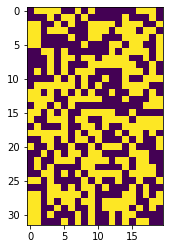

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mask)

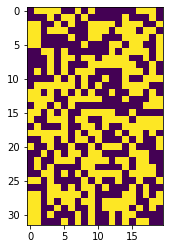

In [6]:
im = np.array(Image.fromarray(mask.astype(bool), mode='L'))
plt.imshow(im, vmin=0, vmax=1)

In [7]:
print(im.size)

640


In [8]:
im = im.reshape(32, 20)

In [9]:
def resizeMask(im, side_length):
    old_size = im.size
    ratio = float(side_length)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new('L', (side_length, side_length))
    new_im.paste(im, ((side_length-new_size[0])//2,
                        (side_length-new_size[1])//2))

    return new_im

In [11]:
new_image = resizeMask(im, SIDE_LENGTH)
plt.imshow(new_image)

TypeError: 'int' object is not iterable

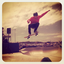

In [12]:
# Sample
path = os.path.join(COCO_VAL_IMG_PATH, '000000581357.jpg')
resizeImage(Image.open(path), SIDE_LENGTH)

In [13]:
val_ids = np.load('val_indexes.npy')
val_map = np.load('val_map.npy', allow_pickle=True).item()

In [14]:
print(n_ids)

NameError: name 'n_ids' is not defined

In [15]:
# # Loop through IDs, create path w/ IDs, and make into tensor
# x_val = []
# y_val = []

# n_ids = len(val_ids)
# for i in range(n_ids):
#     if i % 300 == 0:
#         print('Iteration', i)
#     pid = val_ids[i]
#     im_path = os.path.join(COCO_VAL_IMG_PATH, str(pid).zfill(12) + '.jpg')
#     im = np.array(Image.open(im_path))
#     if (len(im.shape) < 3):
#         continue
#     image_data = val_map[pid]
    
#     for i in range(len(image_data)):
#         x1, y1, w, h = [int(x) for x in image_data[i][0]]
#         rle_mask = image_data[i][1]
#         decoded = cmask.decode(rle_mask)
#         crop = im[y1:y1+h, x1:x1+w, :]
#         crop_mask = decoded[y1:y1+h, x1:x1+w]
#         crop_resize = resizeImage(Image.fromarray(crop), SIDE_LENGTH)
#         x_val.append(np.array(crop_resize))
        
#         mask_resize = resizeMask(Image.fromarray(crop_mask, mode='L'), SIDE_LENGTH)
#         y_val.append(np.array(mask_resize))

# x_val = np.array(x_val)
# y_val = np.array(y_val)

Iteration 0
Iteration 300
Iteration 600
Iteration 900
Iteration 1200
Iteration 1500
Iteration 1800
Iteration 2100
Iteration 2400


In [17]:
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)

In [5]:
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')
x_val_reshape = x_val.reshape((x_val.shape[0], -1))
y_val_reshape = y_val.reshape((x_val.shape[0], -1))

In [7]:
import keras.backend as K
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=False)

In [22]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.metrics import binary_accuracy

N_MODS = 10

model = Sequential()
model.add(Dense(1500, input_dim=SIDE_LENGTH * SIDE_LENGTH * 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

for n in range(N_MODS):
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

model.add(Dense(1500))
model.add(Activation('relu'))
model.add(BatchNormalization())
    
model.add(Dense(SIDE_LENGTH*SIDE_LENGTH))
model.add(Activation('sigmoid'))
model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss=binary_crossentropy_with_logits,
                metrics=[binary_accuracy])

In [18]:
import matplotlib.pyplot as plt

In [19]:
ex = x_val[1505:1550]
print(ex.shape)
examples = model.predict(ex.reshape((-1, SIDE_LENGTH * SIDE_LENGTH * 3)))

(45, 64, 64, 3)


In [26]:
save_dir = '/home/michael/Code/CS229-Project/Masking/outputs'

In [27]:
for i, example in enumerate(ex):
    example_im = example.reshape((64, 64, 3))
    plt.imsave(save_dir + str(i) + '.png', example_im)

In [29]:
for i, example in enumerate(examples):
    example_im = example.reshape((64, 64)) > 0.5
    plt.imsave(save_dir + str(i) + '.png', example_im)

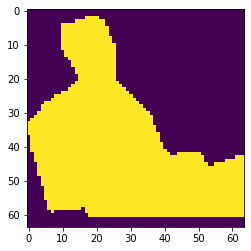

In [36]:
plt.imshow(y_val[1505])

In [23]:
model.fit(x_val_reshape, y_val_reshape, epochs=7, batch_size=32)

Epoch 1/7
10941/10941 [==============================] - 14s 1ms/step - loss: 0.6331 - binary_accuracy: 0.6802
Epoch 2/7
10941/10941 [==============================] - 11s 960us/step - loss: 0.4346 - binary_accuracy: 0.8175
Epoch 3/7
10941/10941 [==============================] - 11s 972us/step - loss: 0.3492 - binary_accuracy: 0.8322
Epoch 4/7
10941/10941 [==============================] - 11s 976us/step - loss: 0.3363 - binary_accuracy: 0.8334
Epoch 5/7
 4960/10941 [============>.................] - ETA: 5s - loss: 0.3326 - binary_accuracy: 0.8346

KeyboardInterrupt: 

In [ ]:
path = 'Models/DenseNet_FCN/checkpoint_weights.hdf5'

In [30]:
print(x_val.shape)
print(y_val.shape)
print(x_val_reshape.shape)

(10941, 64, 64, 3)
(10941, 64, 64)
(10941, 12288)


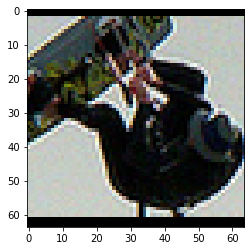

In [16]:
plt.imshow(x_val[0])

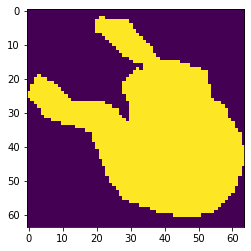

In [17]:
plt.imshow(y_val[0])

In [215]:
x_val_radius = []
y_val_radius = []

In [207]:
DIAM = 5
RADIUS = (DIAM - 1) // 2

In [254]:
x_val_radius = []
y_val_radius = []
i_rand = np.random.choice(x_val.shape[0], 1000, replace=False)
for i in i_rand:
    im = x_val[i]
    j_rand = np.random.choice(range(0+RADIUS, SIDE_LENGTH-RADIUS), 4, replace=False)
    k_rand = np.random.choice(range(0+RADIUS, SIDE_LENGTH-RADIUS), 4, replace=False)
    for j in j_rand:
        for k in k_rand:
            x_val_radius.append(im[j-RADIUS:j+RADIUS+1, k-RADIUS:k+RADIUS+1, :].squeeze())
            y_val_radius.append(y_val[i][j][k].squeeze().item())

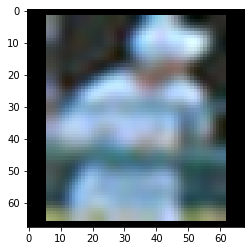

In [265]:
x_val_radius2 = []
y_val_radius2 = []

for i in range(5,15):
    padded = np.pad(x_val[i], ((RADIUS, RADIUS), (RADIUS, RADIUS), (0,0)), mode='constant', constant_values=0)
    plt.imshow(padded)
    if i % 300 == 0:
        print('Iteration', i)
    for j in range(RADIUS, SIDE_LENGTH + RADIUS):
        for k in range(RADIUS, SIDE_LENGTH + RADIUS):
            x_val_radius2.append(padded[j-RADIUS:j+RADIUS+1, k-RADIUS:k+RADIUS+1, :].squeeze())
            y_val_radius2.append(y_val[i][j-RADIUS][k-RADIUS].squeeze().item())

In [260]:
x_val_radius = np.array(x_val_radius)
y_val_radius = np.array(y_val_radius)
print(x_val_radius.shape)
print(y_val_radius.shape)

(16000, 75)
(16000,)


In [268]:
x_val_radius2 = np.array(x_val_radius2)
y_val_radius2 = np.array(y_val_radius2)
print(x_val_radius2.shape)
print(y_val_radius2.shape)

(40960, 75)
(40960,)


In [258]:
x_val_radius = np.reshape(x_val_radius, (x_val_radius.shape[0], -1))


In [267]:
x_val_radius2 = np.reshape(x_val_radius2, (x_val_radius2.shape[0], -1))

In [269]:
OFFSET = 6
VAL = 64*64

In [263]:
x_val_radius = x_val_radius[OFFSET*VAL:(OFFSET + 3)*VAL]
y_val_radius = y_val_radius[OFFSET*VAL:(OFFSET + 3)*VAL]

In [270]:
x_val_radius2 = x_val_radius2[OFFSET*VAL:(OFFSET + 3)*VAL]
y_val_radius2 = y_val_radius2[OFFSET*VAL:(OFFSET + 3)*VAL]

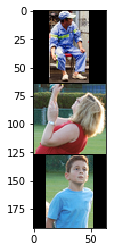

In [206]:
plt.imshow(x_val_radius.reshape((192, 64,3)))

In [81]:
## MODEL

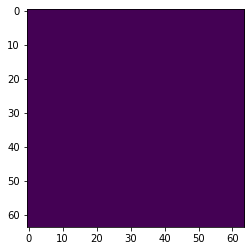

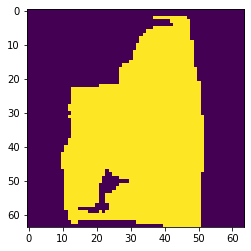

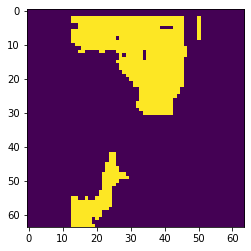

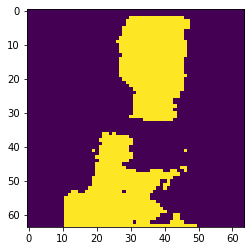

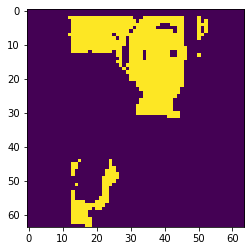

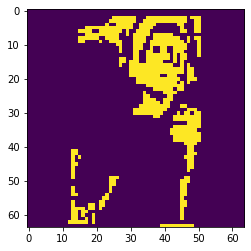

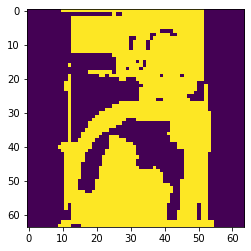

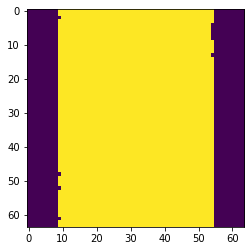

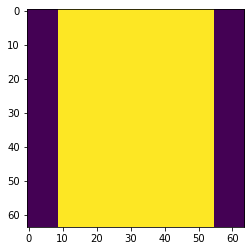

In [273]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
masks = []
gamma_vals = [1E-9, 1E-8, 5E-7, 1E-7, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
for gamma in gamma_vals:
    clf = SVC(gamma=gamma)
    clf.fit(x_val_radius[:-(64*64)], y_val_radius[:-(64*64)])
    outputs = clf.predict(x_val_radius2[-(64*64):])
    mask = outputs.reshape(64, 64)
    masks.append(mask)
    plt.imshow(mask)
    plt.show()

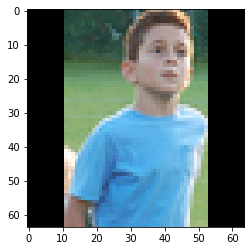

In [170]:
plt.imshow(x_val_radius[-(64*64):].reshape(64,64,3))

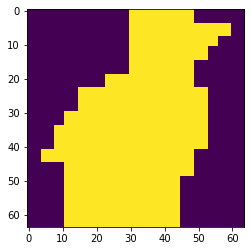

In [168]:
plt.imshow(y_val_radius[-(64*64):].reshape(64,64))

In [172]:
test_x = x_val_radius[-(64*64):].reshape(64,64,3)
test = y_val_radius[-(64*64):].reshape(64,64)
print(masks[2].shape)

(64, 64)


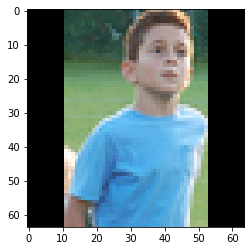

In [173]:
plt.imshow(test_x)

In [280]:
same = np.where(masks[3][:, 11:55] == test[:,11:55])

In [281]:
accuracy = len(same[0]) / (64*64)

In [282]:
print('Accuracy:', accuracy)

Accuracy: 0.511962890625
